In [38]:
import pandas as pd

In [39]:
imdb_data= pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
imdb_data.shape

(50000, 2)

In [40]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [41]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [42]:
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer



In [43]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text,remove_digits=True)
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [44]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [54]:
stopword_list=stopwords.words('english')
tokenizer=ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [55]:
norm_train_x=imdb_data.review[:40000]
norm_test_x=imdb_data.review[40000:]

In [57]:
norm_test_x.shape,norm_train_x.shape

((10000,), (40000,))

In [58]:
#bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_x=cv.fit_transform(norm_train_x)
#transformed test reviews
cv_test_x=cv.transform(norm_test_x)

print('BOW_cv_train:',cv_train_x.shape)
print('BOW_cv_test:',cv_test_x.shape)

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


In [59]:
#tf-idf
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_x=tv.fit_transform(norm_train_x)
#transformed test reviews
tv_test_x=tv.transform(norm_test_x)
print('Tfidf_train:',tv_train_x.shape)
print('Tfidf_test:',tv_test_x.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


In [60]:
from sklearn.preprocessing import LabelBinarizer

lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [61]:
train_y=imdb_data.sentiment[:40000]
test_y=imdb_data.sentiment[40000:]

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
# modelling the data
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_x,train_y)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_x,train_y)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [63]:
lr_bow_predict=lr.predict(cv_test_x)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_x)

In [64]:
lr_bow_score=accuracy_score(test_y,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_y,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


In [67]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_y,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_y,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



<function matplotlib.pyplot.show(*args, **kw)>

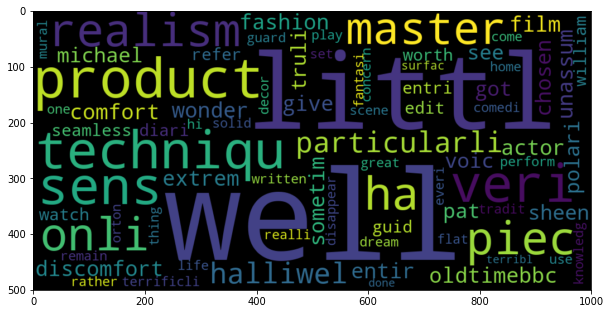

In [71]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_x[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

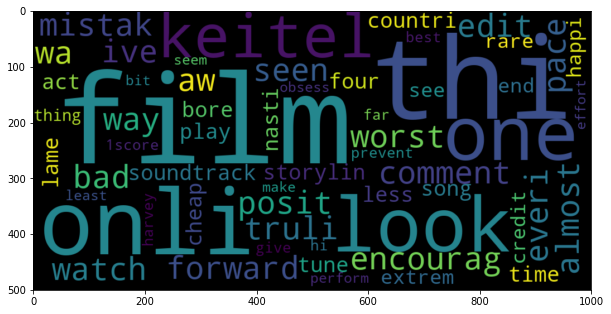

In [72]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_x[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show